### 🚀 For an interactive experience, head over to our [demo platform](https://var.vision/demo) and dive right in! 🌟

In [1]:
!git clone https://github.com/lijrjyan/VAR.git
!mv VAR/* /content

Cloning into 'VAR'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 251 (delta 96), reused 76 (delta 76), pack-reused 132 (from 2)
Receiving objects: 100% (251/251), 673.48 KiB | 22.45 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [2]:
################## 1. Download checkpoints and build models
import os
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var_speculative_decoding
from IPython.display import display

In [4]:
TARGET_MODEL_DEPTH = 30    # TODO: =====> please specify MODEL_DEPTH <=====
assert TARGET_MODEL_DEPTH in {16, 20, 24, 30}

DRAFT_MODEL_DEPTH = 16    # TODO: =====> please specify MODEL_DEPTH <=====
assert DRAFT_MODEL_DEPTH in {16, 20, 24, 30}

# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, target_var_ckpt, draft_var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{TARGET_MODEL_DEPTH}.pth', f'var_d{DRAFT_MODEL_DEPTH}.pth'
if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
if not osp.exists(target_var_ckpt): os.system(f'wget {hf_home}/{target_var_ckpt}')
if not osp.exists(draft_var_ckpt): os.system(f'wget {hf_home}/{draft_var_ckpt}')

In [6]:
# build vae, var
patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'vae' not in globals() or 'draft_var' not in globals() or 'target_var' not in globals():
    vae, draft_var, target_var = build_vae_var_speculative_decoding(
        V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
        device=device, patch_nums=patch_nums,
        num_classes=1000, depth_draft=DRAFT_MODEL_DEPTH, depth_target=TARGET_MODEL_DEPTH, shared_aln=False,
    )

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
draft_var.load_state_dict(torch.load(draft_var_ckpt, map_location='cpu'), strict=True)
target_var.load_state_dict(torch.load(target_var_ckpt, map_location='cpu'), strict=True)
vae.eval(), draft_var.eval(), target_var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in draft_var.parameters(): p.requires_grad_(False)
for p in target_var.parameters(): p.requires_grad_(False)
print(f'prepare finished.')

<ipython-input-6-547d5451ad1f>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
<ipython-input-6-

prepare finished.


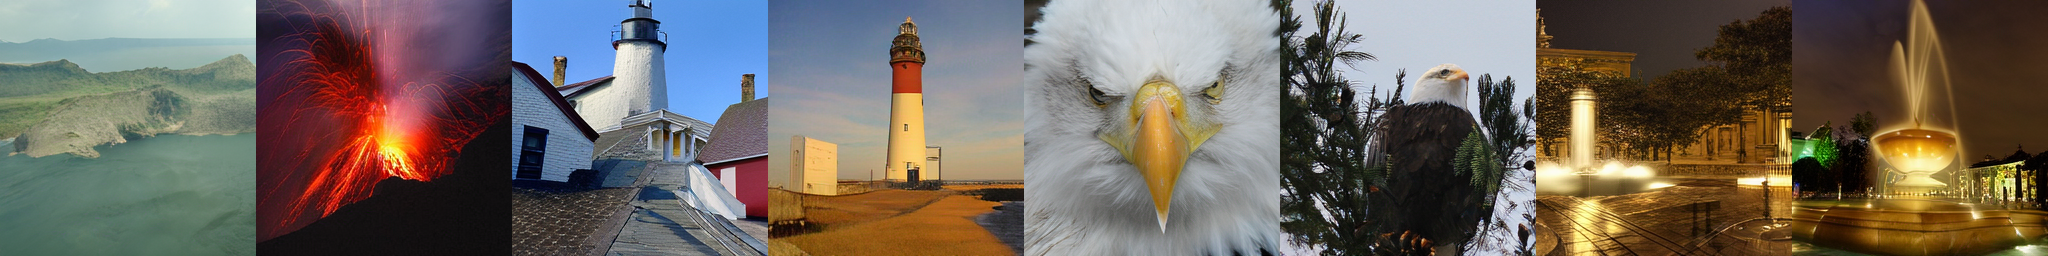

In [ ]:
############################# 2. Sample with classifier-free guidance

# set args
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = (980, 980, 437, 437, 22, 22, 562, 562)  #@param {type:"raw"}
more_smooth = False # True for more smooth output

# seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

# sample
B = len(class_labels)
label_B: torch.LongTensor = torch.tensor(class_labels, device=device)
with torch.inference_mode():
    with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
        recon_B3HW = var.autoregressive_infer_cfg(B=B, label_B=label_B, cfg=cfg, top_k=900, top_p=0.95, g_seed=seed, more_smooth=more_smooth)

chw = torchvision.utils.make_grid(recon_B3HW, nrow=8, padding=0, pad_value=1.0)
chw = chw.permute(1, 2, 0).mul_(255).cpu().numpy()
chw = PImage.fromarray(chw.astype(np.uint8))
display(chw)
chw.show()


In [ ]:



# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'

if not osp.exists(draft_vae_ckpt): os.system(f'wget {hf_home}/{draft_vae_ckpt}')


# build vae, var
draft_device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'draft_vae' not in globals() or 'draft_var' not in globals():
    draft_vae, draft_var = build_vae_var(
        V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
        device=device, patch_nums=patch_nums,
        num_classes=1000, depth=DRAFT_MODEL_DEPTH, shared_aln=False,
    )

# load checkpoints
draft_vae.load_state_dict(torch.load(draft_vae_ckpt, map_location='cpu'), strict=True)
draft_var.load_state_dict(torch.load(draft_var_ckpt, map_location='cpu'), strict=True)
draft_vae.eval(), draft_var.eval()
for p in draft_vae.parameters(): p.requires_grad_(False)
for p in draft_var.parameters(): p.requires_grad_(False)
print(f'prepare finished.')


[constructor]  ==== flash_if_available=True (0/16), fused_if_available=True (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=1024, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))

[init_weights] VAR with init_std=0.0180422


<ipython-input-6-f874b6856028>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  draft_vae.load_state_dict(torch.load(draft_vae_ckpt, map_location='cpu'), strict=True)
<ipyt

prepare finished.


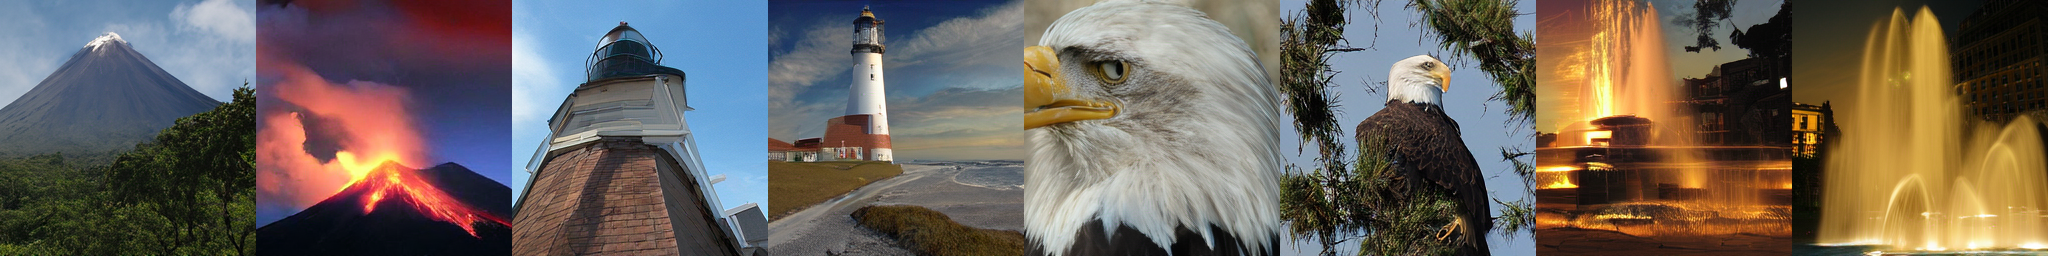

In [ ]:
############################# 2. Sample with classifier-free guidance

# set args
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = (980, 980, 437, 437, 22, 22, 562, 562)  #@param {type:"raw"}
more_smooth = False # True for more smooth output

# seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

# sample
B = len(class_labels)
label_B: torch.LongTensor = torch.tensor(class_labels, device=device)
with torch.inference_mode():
    with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
        recon_B3HW = draft_var.autoregressive_infer_cfg(B=B, label_B=label_B, cfg=cfg, top_k=900, top_p=0.95, g_seed=seed, more_smooth=more_smooth)

chw = torchvision.utils.make_grid(recon_B3HW, nrow=8, padding=0, pad_value=1.0)
chw = chw.permute(1, 2, 0).mul_(255).cpu().numpy()
chw = PImage.fromarray(chw.astype(np.uint8))
display(chw)
chw.show()